In [46]:
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

BW_METHOD = 0.1

In [2]:
mnist = fetch_openml(name='mnist_784', version='active')

In [3]:
pca = PCA(n_components=128)
data = pca.fit_transform(mnist.data)

In [4]:
data = data.T
data.shape

(128, 70000)

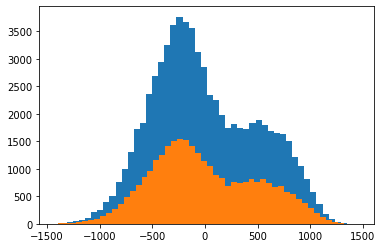

In [5]:
i = 1
plt.hist(data[i], bins=50)
kernel = gaussian_kde(data, bw_method=BW_METHOD)
sample = kernel.resample(30_000)
_ = plt.hist(sample[i], bins=50)

### Training the model

In [37]:
mnist_train = MNIST(root='../datasets', train=True, transform=transforms.ToTensor(), download=True)

In [40]:
class IdxDataset(Dataset):
    """Wrap a dataset to map indices to images
    In other words, instead of producing (X, y) it produces (idx, X). The label
    y is not relevant for our task.
    """
    def __init__(self, base_dataset):
        self.base = base_dataset

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, target = self.base[idx]
        return (idx, img, target)
        

mnist_train = IdxDataset(mnist_train)

In [44]:
train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

In [59]:
_, img = zip(*[(idx, img_) for idx, img_, _ in train_loader])
img = torch.cat(img)

In [63]:
res = img.view(img.shape[0], -1).numpy()

In [70]:
def generate_samples(dataloader, z_dim=128, bw_method=0.1):
    _, img = zip(*[(idx, img_) for idx, img_, _ in dataloader])
    img = torch.cat(img)
    img = img.view(img.shape[0], -1).numpy()
    pca = PCA(n_components=z_dim)
    z_dataset = pca.fit_transform(img).T
    kernel = gaussian_kde(z_dataset, bw_method=bw_method)
    samples = kernel.resample(size=len(dataloader.dataset)).T
    samples = torch.tensor(samples, requires_grad=True)
    return samples

In [71]:
z = generate_samples(train_loader)

In [73]:
z.shape

torch.Size([60000, 128])

In [76]:
_, sample, _ = next(iter(train_loader))
sample.shape

torch.Size([8, 1, 28, 28])